In [2]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
import numpy as np
from admm.agents import FedConsensus
from admm.servers import EventADMM
from admm.models import FCNet, CNN
from admm.utils import average_params
from admm.data import partition_data, split_dataset
import seaborn as sns
sns.set_theme()

%matplotlib inline

In [3]:
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_trainset = datasets.CIFAR10(
    root='./data/cifar10', train=True,
    download=True, transform=cifar_transform
)
cifar_testset = datasets.CIFAR10(
    root='./data/cifar10', train=False,
    download=True, transform=cifar_transform
)

mnist_transform = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,)), transforms.Lambda(lambda x: torch.flatten(x))
])

mnist_trainset = datasets.MNIST(
    root='./data/mnist_data', train=True,
    download=True, transform=mnist_transform, 
)
mnist_testset = datasets.MNIST(
    root='./data/mnist_data', train=False,
    download=True, transform=mnist_transform
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
train_dataset, val_dataset, _ = split_dataset(dataset=mnist_trainset, train_ratio=0.8, val_ratio=0.2)

trainsets = partition_data(
    num_clients=10,
    iid=False,
    balance=True,
    power_law=True,
    seed=42,
    trainset=train_dataset.dataset,
    labels_per_partition=1
)

for i, dataset in enumerate(trainsets):
    labels = np.zeros(10)
    loader = DataLoader(dataset, batch_size=1)
    for data, target in loader:
        labels[target.item()] += 1
    print(f'Dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

labels = np.zeros(10)
loader = DataLoader(val_dataset, batch_size=1)
for data, target in loader:
    labels[target.item()] += 1
print(f'Validation dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

oader = DataLoader(val_dataset, batch_size=10)
for data, target in loader:
    print(data.shape)
    break

Dataset 0 distribution: [5421.    0.    0.    0.    0.    0.    0.    0.    0.    0.] - num_samples = 5421.0
Dataset 1 distribution: [   0. 5421.    0.    0.    0.    0.    0.    0.    0.    0.] - num_samples = 5421.0
Dataset 2 distribution: [   0.    0. 5421.    0.    0.    0.    0.    0.    0.    0.] - num_samples = 5421.0
Dataset 3 distribution: [   0.    0.    0. 5421.    0.    0.    0.    0.    0.    0.] - num_samples = 5421.0
Dataset 4 distribution: [   0.    0.    0.    0. 5421.    0.    0.    0.    0.    0.] - num_samples = 5421.0
Dataset 5 distribution: [   0.    0.    0.    0.    0. 5421.    0.    0.    0.    0.] - num_samples = 5421.0
Dataset 6 distribution: [   0.    0.    0.    0.    0.    0. 5421.    0.    0.    0.] - num_samples = 5421.0
Dataset 7 distribution: [   0.    0.    0.    0.    0.    0.    0. 5421.    0.    0.] - num_samples = 5421.0
Dataset 8 distribution: [   0.    0.    0.    0.    0.    0.    0.    0. 5420.    0.] - num_samples = 5420.0
Dataset 9 distribut

In [27]:
indices = list(range(0,500))
val_indices = list(range(0,12000,12))
# val_indices = list(range(0,100))
sampled_trainsets = [torch.utils.data.Subset(dataset, indices) for dataset in trainsets]
sampled_valset = torch.utils.data.Subset(val_dataset, val_indices) 

for i, dataset in enumerate(sampled_trainsets):
    labels = np.zeros(10)
    loader = DataLoader(dataset, batch_size=1)
    for data, target in loader:
        labels[target.item()] += 1
    print(f'Dataset {i} distribution: {labels} - num_samples = {labels.sum()}')

labels = np.zeros(10)
loader = DataLoader(sampled_valset, batch_size=1)
for data, target in loader:
    labels[target.item()] += 1
print(f'Validation dataset {i} distribution: {labels} - num_samples = {labels.sum()}')
    

Dataset 0 distribution: [500.   0.   0.   0.   0.   0.   0.   0.   0.   0.] - num_samples = 500.0
Dataset 1 distribution: [  0. 500.   0.   0.   0.   0.   0.   0.   0.   0.] - num_samples = 500.0
Dataset 2 distribution: [  0.   0. 500.   0.   0.   0.   0.   0.   0.   0.] - num_samples = 500.0
Dataset 3 distribution: [  0.   0.   0. 500.   0.   0.   0.   0.   0.   0.] - num_samples = 500.0
Dataset 4 distribution: [  0.   0.   0.   0. 500.   0.   0.   0.   0.   0.] - num_samples = 500.0
Dataset 5 distribution: [  0.   0.   0.   0.   0. 500.   0.   0.   0.   0.] - num_samples = 500.0
Dataset 6 distribution: [  0.   0.   0.   0.   0.   0. 500.   0.   0.   0.] - num_samples = 500.0
Dataset 7 distribution: [  0.   0.   0.   0.   0.   0.   0. 500.   0.   0.] - num_samples = 500.0
Dataset 8 distribution: [  0.   0.   0.   0.   0.   0.   0.   0. 500.   0.] - num_samples = 500.0
Dataset 9 distribution: [  0.   0.   0.   0.   0.   0.   0.   0.   0. 500.] - num_samples = 500.0
Validation dataset 9

In [70]:
batch_size = 1
train_loaders = [DataLoader(dataset, batch_size=batch_size, shuffle=True) for dataset in sampled_trainsets]
test_loader = DataLoader(mnist_testset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(sampled_valset, batch_size=50, shuffle=True)

In [81]:
lr = 0.001
deltas = np.arange(start=0.7, stop=1.5, step=0.03).tolist()
deltas = [0, *deltas]
# deltas = [1.28]
# deltas = [0.5, 0.6, 0.7, 0.8]
print(f'testing for {len(deltas)} deltas')
rho = 1
rhos = [0.0001, 0.001, 0.01, 0.1, 1]
t_max = 300
loaders = train_loaders
device = 'cpu'

acc_per_delta = np.zeros((len(deltas), t_max))
rate_per_delta = np.zeros((len(deltas), t_max))
loads = []
test_accs = []

print(f'N = {len(loaders)}')
_N = 0
for loader in loaders:
    _N += len(loader.dataset)

for i, delta in enumerate(deltas):
    
    agents = []
    for loader in loaders:
        torch.manual_seed(78)
        model = FCNet(in_channels=784, hidden1=200, hidden2=None, out_channels=10)
        agents.append(
            FedConsensus(
                N=len(loaders),
                delta=delta,
                rho=rho,
                model=model,
                loss=nn.CrossEntropyLoss(),
                train_loader=loader,
                epochs=1,
                data_ratio=len(loader.dataset)/_N,
                device=device,
                lr=lr
            ) 
        )

    # Broadcast average to all agents and check if equal
    for agent in agents:
        agent.primal_avg = average_params([agent.model.parameters() for agent in agents])
    
    # Check that all agents start with same params
    # for agent1 in agents:
    #     for agent2 in agents:
    #         for param1, param2 in zip(agent1.model.parameters(), agent2.model.parameters()):
    #             if not torch.equal(param1, param2): raise ValueError("Initial params aren't equal")
    
    # # Check to make sure they all start with the same average
    # for agent1 in agents:
    #     for agent2 in agents:
    #         for param1, param2 in zip(agent1.primal_avg, agent2.primal_avg):
    #             param1, param2 = torch.Tensor(param1), torch.Tensor(param2)
    #             if not torch.equal(param1, param2): raise ValueError("Averaged params aren't equal")
    #             if torch.equal(param1, torch.zeros(param1.shape)) or torch.equal(param2, torch.zeros(param1.shape)):
    #                 raise ValueError('Averaged Params are zero')
    # print('Parameter check complete!')

    # Run consensus algorithm
    server = EventADMM(clients=agents, t_max=t_max)
    server.spin(loader=val_loader)
    final = agents[0].last_communicated
    # For plotting purposes
    acc_per_delta[i,:] = server.val_accs
    rate_per_delta[i,:] = server.rates
    loads = [sum(rate_per_delta[i,:])/t_max for i in range(len(deltas))]
    accs = server.validate(loader=test_loader)
    test_accs.append(sum(accs)/len(accs))

testing for 28 deltas
N = 10


Comm: 1.000, Global Acc = 0.9220, min Delta: 0.83766366, max Delta: 1.07231744, avg: 0.94884641: 100%|██████████| 300/300 [01:33<00:00,  3.20it/s]
Comm: 1.000, Global Acc = 0.9250, min Delta: 0.81753525, max Delta: 1.25886526, avg: 1.04699522: 100%|██████████| 300/300 [01:30<00:00,  3.32it/s]
Comm: 0.900, Global Acc = 0.7210, min Delta: 0.70114102, max Delta: 0.96726939, avg: 0.78900440:   2%|▏         | 7/300 [00:02<01:28,  3.30it/s]

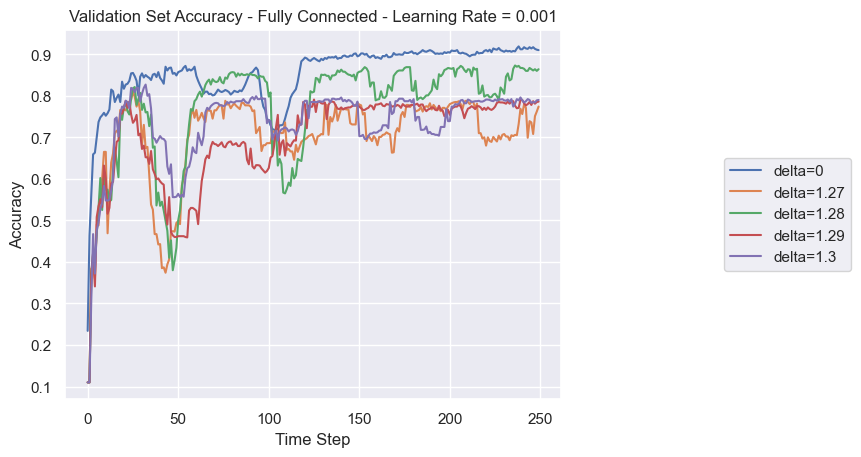

In [62]:
T = range(t_max)
# Plot accuracies
for acc, delta in zip(acc_per_delta, deltas):
    plt.plot(T, acc, label=f'delta={delta:.2f}')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracy - Fully Connected - Learning Rate = 0.001')
plt.show()

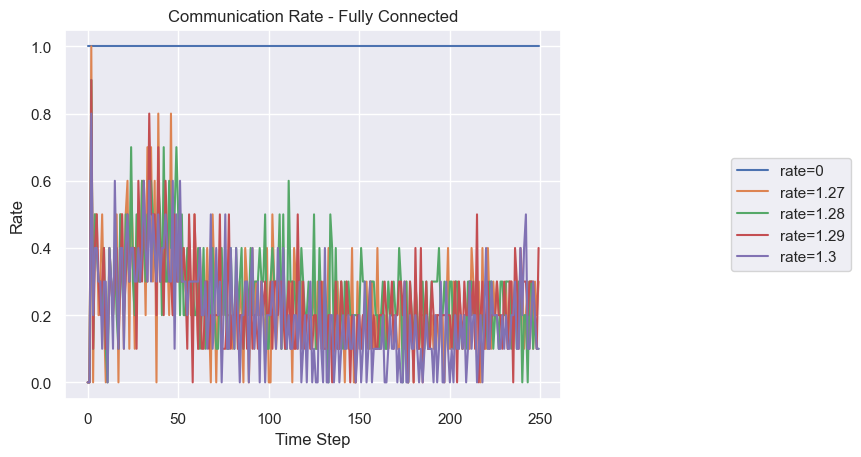

In [63]:
for rate, delta in zip(rate_per_delta, deltas):
    plt.plot(T, rate, label=f'rate={delta:.2f}')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Rate')
plt.title('Communication Rate - Fully Connected')
plt.show()

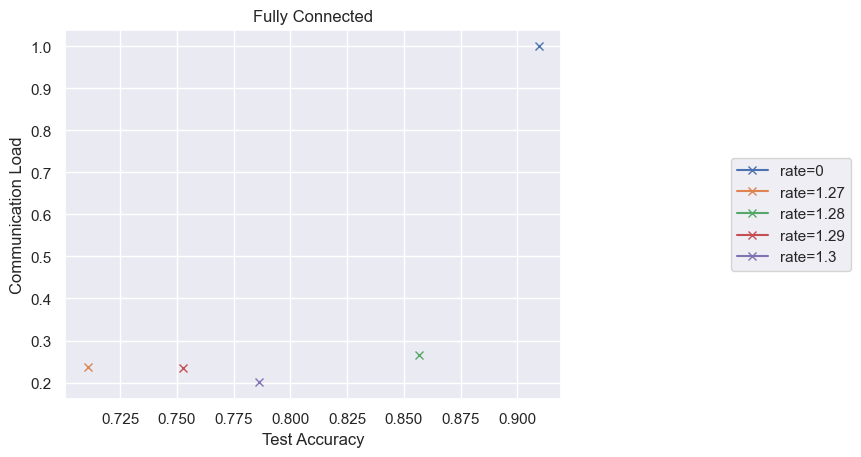

In [64]:
for load, acc, delta in zip(loads, test_accs, deltas):
    plt.plot(acc, load, label=f'rate={delta:.2f}', marker='x')
plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5))
plt.xlabel('Test Accuracy')
plt.ylabel('Communication Load')
plt.title('Fully Connected')
plt.show()